# Neural Network Solution for Continuous-Time Neoclassical Growth Model

This notebook uses neural networks to solve the continuous-time neoclassical growth model by minimizing the HJB residual.

## Model Setup

- **State variable**: Capital stock $k(t)$
- **Control variable**: Consumption $c(t)$
- **Value function**: $V(k)$
- **Objective**: Minimize HJB residual

In [1]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import grad
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set matplotlib parameters
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

Using device: cpu


## Global Parameters

In [2]:
# Global parameters
rho = 0.05      # Discounting factor
alpha = 0.3     # Yield of capital
delta = 0.1     # Depreciation factor
gamma = 2.0     # Utility function parameter

# Capital stock range [k_min, k_max]
k_min = 0.1
k_max = 10.0

print("Model parameters:")
print(f"  rho (discounting factor): {rho}")
print(f"  alpha (yield of capital): {alpha}")
print(f"  delta (depreciation factor): {delta}")
print(f"  gamma (utility function parameter): {gamma}")
print(f"  Capital stock range: [{k_min}, {k_max}]")

Model parameters:
  rho (discounting factor): 0.05
  alpha (yield of capital): 0.3
  delta (depreciation factor): 0.1
  gamma (utility function parameter): 2.0
  Capital stock range: [0.1, 10.0]


## Neural Network Architecture

Neural network for approximating the value function $V(k)$

In [3]:
class ValueFunctionNet(nn.Module):
    """
    Neural network for approximating the value function V(k)
    """
    def __init__(self, hidden_layers=[64, 64, 64], activation=nn.Tanh):
        super(ValueFunctionNet, self).__init__()
        
        layers = []
        input_dim = 1  # Input is capital stock k
        
        # Build hidden layers
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(activation())
            input_dim = hidden_dim
        
        # Output layer (value function value)
        layers.append(nn.Linear(input_dim, 1))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, k):
        """
        Forward pass
        Args:
            k: Capital stock (batch_size, 1)
        Returns:
            V: Value function value (batch_size, 1)
        """
        return self.network(k)

# Create neural network instance
net = ValueFunctionNet(hidden_layers=[64, 64, 64]).to(device)

# Initialize network weights for better training
def init_weights(m):
    """Initialize network weights"""
    if isinstance(m, nn.Linear):
        # Xavier/Glorot initialization for better gradient flow
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

net.apply(init_weights)

print("Neural network architecture:")
print(net)
print("Network weights initialized with Xavier uniform initialization")

Neural network architecture:
ValueFunctionNet(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
Network weights initialized with Xavier uniform initialization


## Helper Functions

Define helper functions for computing gradients and HJB residuals

In [4]:
def compute_gradients(V, k):
    """
    Compute gradient of value function with respect to capital stock dV/dk
    Args:
        V: Value function value
        k: Capital stock
    Returns:
        dV_dk: Gradient
    """
    dV_dk = grad(V, k, grad_outputs=torch.ones_like(V), 
                 create_graph=True, retain_graph=True)[0]
    return dV_dk

def production_function(k):
    """
    Production function: f(k) = k^alpha
    """
    return k ** alpha

def utility_function(c, gamma=gamma):
    """
    Utility function: u(c) = c^(1-gamma) / (1-gamma) if gamma != 1
                      u(c) = log(c) if gamma == 1
    """
    if gamma == 1.0:
        return torch.log(c + 1e-8)  # Add small value to avoid log(0)
    else:
        return (c ** (1 - gamma)) / (1 - gamma)

def consumption_from_foc(dV_dk, gamma=gamma):
    """
    Derive optimal consumption from first-order condition
    u'(c) = dV/dk
    For CRRA utility function: c^(-gamma) = dV/dk
    Therefore: c = (dV/dk)^(-1/gamma)
    """
    # Ensure dV_dk > 0
    dV_dk = torch.clamp(dV_dk, min=1e-8)
    c = dV_dk ** (-1.0 / gamma)
    return c

def utility_derivative(c, gamma=gamma):
    """
    Derivative of utility function: u'(c)
    For CRRA utility: u'(c) = c^(-gamma) if gamma != 1
                       u'(c) = 1/c if gamma == 1
    """
    if gamma == 1.0:
        return 1.0 / (c + 1e-8)  # Add small value to avoid division by zero
    else:
        return c ** (-gamma)

print("Helper functions defined")

Helper functions defined


## Loss Function Framework

A framework is provided here. You can customize the loss function later.

In [5]:
def compute_hjb_residual(net, k):
    """
    Compute HJB residual (framework function, you can customize later)
    
    General form of HJB equation:
    rho * V(k) = max_c { u(c) + V'(k) * [f(k) - delta*k - c] }
    
    Args:
        net: Neural network
        k: Capital stock (batch_size, 1)
    Returns:
        residual: HJB residual
    """
    k.requires_grad_(True)
    
    # Compute value function
    V = net(k)
    
    # Compute gradient dV/dk
    dV_dk = compute_gradients(V, k)
    
    # Get optimal consumption from first-order condition
    c = consumption_from_foc(dV_dk, gamma)
    
    # Production function
    f_k = production_function(k)
    
    # Capital accumulation equation: dk/dt = f(k) - delta*k - c
    dk_dt = f_k - delta * k - c
    
    # Utility function
    u_c = utility_function(c, gamma)
    
    # HJB equation: rho * V = u(c) + V'(k) * dk/dt
    hjb_lhs = rho * V
    hjb_rhs = u_c + dV_dk * dk_dt
    
    # Residual
    residual = hjb_lhs - hjb_rhs
    
    return residual, V, c, dV_dk

def loss_function(net, k_samples):
    """
    Loss = mean squared HJB residual only.
    The standard model has FOC u'(c)=V'(k) (already used to get c); the only
    equation to enforce is the HJB: rho*V = u(c) + V'(k)*(f(k)-delta*k-c).
    """
    hjb_residual, V, c, dV_dk = compute_hjb_residual(net, k_samples)
    loss = torch.mean(hjb_residual ** 2)
    return loss

print("Loss function framework defined. You can customize it later.")

Loss function framework defined. You can customize it later.


## Training Function

In [6]:
def train_model(net, num_epochs=1000, batch_size=128, lr=0.001, 
                num_samples=1000, print_every=100, use_scheduler=True):
    """
    Train neural network
    
    Args:
        net: Neural network
        num_epochs: Number of training epochs
        batch_size: Batch size
        lr: Learning rate
        num_samples: Number of sample points per iteration
        print_every: Print every N epochs
        use_scheduler: Whether to use learning rate scheduler
    """
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    # Learning rate scheduler - reduces LR when loss plateaus
    if use_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=500, 
            min_lr=1e-6
        )
        prev_lr = optimizer.param_groups[0]['lr']
    
    # Record training history
    loss_history = []
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Random sampling in [k_min, k_max] range
        k_samples = torch.rand(num_samples, 1, device=device) * (k_max - k_min) + k_min
        k_samples.requires_grad_(True)
        
        # Forward pass
        optimizer.zero_grad()
        loss = loss_function(net, k_samples)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Update learning rate scheduler
        if use_scheduler:
            scheduler.step(loss.item())
            current_lr = optimizer.param_groups[0]['lr']
            # Print when learning rate is reduced
            if current_lr < prev_lr:
                print(f"Learning rate reduced to {current_lr:.2e} at epoch {epoch+1}")
                prev_lr = current_lr
        
        # Record loss
        loss_value = loss.item()
        loss_history.append(loss_value)
        if loss_value < best_loss:
            best_loss = loss_value
        
        # Print progress
        if (epoch + 1) % print_every == 0:
            current_lr = optimizer.param_groups[0]['lr']
            # Convert loss to scientific notation (power of 10)
            loss_power = np.log10(loss_value) if loss_value > 0 else -np.inf
            best_power = np.log10(best_loss) if best_loss > 0 else -np.inf
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_value:.6f} (10^{loss_power:.2f}), Best: {best_loss:.6f} (10^{best_power:.2f}), LR: {current_lr:.2e}")
    
    return loss_history

print("Training function defined")

Training function defined


## Visualization Functions

In [7]:
from matplotlib.ticker import FuncFormatter

def _loss_axis_formatter(x, pos):
    """Format y-axis as 10^{-1.4}, 10^{-2}, ... for loss visualization."""
    if x <= 0:
        return ''
    p = np.log10(x)
    return r'$10^{{{:.1f}}}$'.format(p)

def visualize_results(net, k_test=None, save_path=None):
    """
    Visualize results
    
    Args:
        net: Trained neural network
        k_test: Test points (if None, automatically generated)
        save_path: Save path (optional)
    """
    net.eval()
    
    if k_test is None:
        k_test = np.linspace(k_min, k_max, 200)
    
    k_tensor = torch.tensor(k_test, dtype=torch.float32, device=device).reshape(-1, 1)
    
    # Compute value function without gradient (for plotting)
    with torch.no_grad():
        V_pred = net(k_tensor).cpu().numpy().flatten()
    
    # Compute gradient (needs gradient tracking, so outside no_grad)
    k_tensor.requires_grad_(True)
    V = net(k_tensor)
    dV_dk = compute_gradients(V, k_tensor)
    c_pred = consumption_from_foc(dV_dk, gamma).detach().cpu().numpy().flatten()
    
    # Compute HJB residual (needs gradient tracking)
    residual, _, _, _ = compute_hjb_residual(net, k_tensor)
    residual = residual.detach().cpu().numpy().flatten()
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Value function
    axes[0, 0].plot(k_test, V_pred, 'b-', linewidth=2, label='V(k)')
    axes[0, 0].set_xlabel('Capital stock k', fontsize=12)
    axes[0, 0].set_ylabel('Value function V(k)', fontsize=12)
    axes[0, 0].set_title('Value Function', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # 2. Consumption strategy
    axes[0, 1].plot(k_test, c_pred, 'r-', linewidth=2, label='c(k)')
    axes[0, 1].set_xlabel('Capital stock k', fontsize=12)
    axes[0, 1].set_ylabel('Consumption c(k)', fontsize=12)
    axes[0, 1].set_title('Optimal Consumption Strategy', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # 3. HJB residual (signed, linear scale — should be near 0 if solution is good)
    axes[1, 0].plot(k_test, residual, 'g-', linewidth=2, label='HJB Residual')
    axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[1, 0].set_xlabel('Capital stock k', fontsize=12)
    axes[1, 0].set_ylabel('HJB Residual', fontsize=12)
    axes[1, 0].set_title('HJB Residual (should be close to 0)', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # 4. Value function gradient (use already computed dV_dk)
    dV_dk_np = dV_dk.detach().cpu().numpy().flatten()
    
    axes[1, 1].plot(k_test, dV_dk_np, 'm-', linewidth=2, label="V'(k)")
    axes[1, 1].set_xlabel('Capital stock k', fontsize=12)
    axes[1, 1].set_ylabel("Value function gradient V'(k)", fontsize=12)
    axes[1, 1].set_title('Value Function Gradient', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    net.train()

def plot_training_history(loss_history):
    """
    Plot training history with scientific notation and overfitting detection
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Loss with y-axis in powers of 10 (10^{-1}, 10^{-2}, ...)
    ax1.plot(loss_history, 'b-', linewidth=2, alpha=0.7, label='Training Loss')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss History (scale $10^{-n}$)', fontsize=14, fontweight='bold')
    ax1.set_yscale('log')
    ax1.yaxis.set_major_formatter(FuncFormatter(_loss_axis_formatter))
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Same loss with y-axis in powers of 10
    ax2.plot(loss_history, 'r-', linewidth=2, alpha=0.7, label='Training Loss')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Training Loss History (scale $10^{-n}$)', fontsize=14, fontweight='bold')
    ax2.set_yscale('log')
    ax2.yaxis.set_major_formatter(FuncFormatter(_loss_axis_formatter))
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Calculate statistics
    final_loss = loss_history[-1]
    best_loss = min(loss_history)
    final_power = np.log10(final_loss) if final_loss > 0 else -np.inf
    best_power = np.log10(best_loss) if best_loss > 0 else -np.inf
    
    # Detect overfitting: if final loss is significantly higher than best loss
    loss_increase = (final_loss - best_loss) / best_loss if best_loss > 0 else 0
    overfitting_warning = ""
    if loss_increase > 0.1:  # More than 10% increase
        overfitting_warning = f"\n⚠️ Possible overfitting: Loss increased by {loss_increase*100:.1f}%"
    
    # Add text box with loss information
    textstr = f'Final: {final_loss:.6f} (10^{final_power:.2f})\nBest: {best_loss:.6f} (10^{best_power:.2f}){overfitting_warning}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.02, 0.98, textstr, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    # Print overfitting warning if detected
    if loss_increase > 0.1:
        print(f"\n⚠️ Warning: Possible overfitting detected!")
        print(f"   Loss increased from {best_loss:.6f} (10^{best_power:.2f}) to {final_loss:.6f} (10^{final_power:.2f})")
        print(f"   Consider: early stopping, regularization, or reducing model complexity")

print("Visualization functions defined")

Visualization functions defined


In [8]:
# Training parameters - reduced epochs to mitigate overfitting
NUM_EPOCHS = 1000  # Reduced from 5000 to limit overfitting
BATCH_SIZE = 256
LEARNING_RATE = 0.001
NUM_SAMPLES = 3000  # Increased from 2000 for better coverage
USE_SCHEDULER = True  # Enable learning rate scheduling

# Start training
print("Starting neural network training...")
print("=" * 50)
print(f"Training for {NUM_EPOCHS} epochs with {NUM_SAMPLES} samples per iteration")
print(f"Initial learning rate: {LEARNING_RATE}")
print("=" * 50)

loss_history = train_model(
    net, 
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    num_samples=NUM_SAMPLES,
    print_every=200,  # Print every 200 epochs
    use_scheduler=USE_SCHEDULER
)
print("=" * 50)
print("Training completed!")
final_loss = loss_history[-1]
best_loss = min(loss_history)
final_power = np.log10(final_loss) if final_loss > 0 else -np.inf
best_power = np.log10(best_loss) if best_loss > 0 else -np.inf
print(f"Final loss: {final_loss:.6f} (10^{final_power:.2f})")
print(f"Best loss: {best_loss:.6f} (10^{best_power:.2f})")

Starting neural network training...
Training for 1000 epochs with 3000 samples per iteration
Initial learning rate: 0.001
Epoch [200/1000], Loss: 0.024279 (10^-1.61), Best: 0.003453 (10^-2.46), LR: 1.00e-03
Epoch [400/1000], Loss: 0.001669 (10^-2.78), Best: 0.000627 (10^-3.20), LR: 1.00e-03
Epoch [600/1000], Loss: 0.000428 (10^-3.37), Best: 0.000047 (10^-4.33), LR: 1.00e-03
Epoch [800/1000], Loss: 0.000010 (10^-5.02), Best: 0.000010 (10^-5.02), LR: 1.00e-03
Epoch [1000/1000], Loss: 0.000006 (10^-5.22), Best: 0.000006 (10^-5.24), LR: 1.00e-03
Training completed!
Final loss: 0.000006 (10^-5.22)
Best loss: 0.000006 (10^-5.24)


## Visualize Training Results

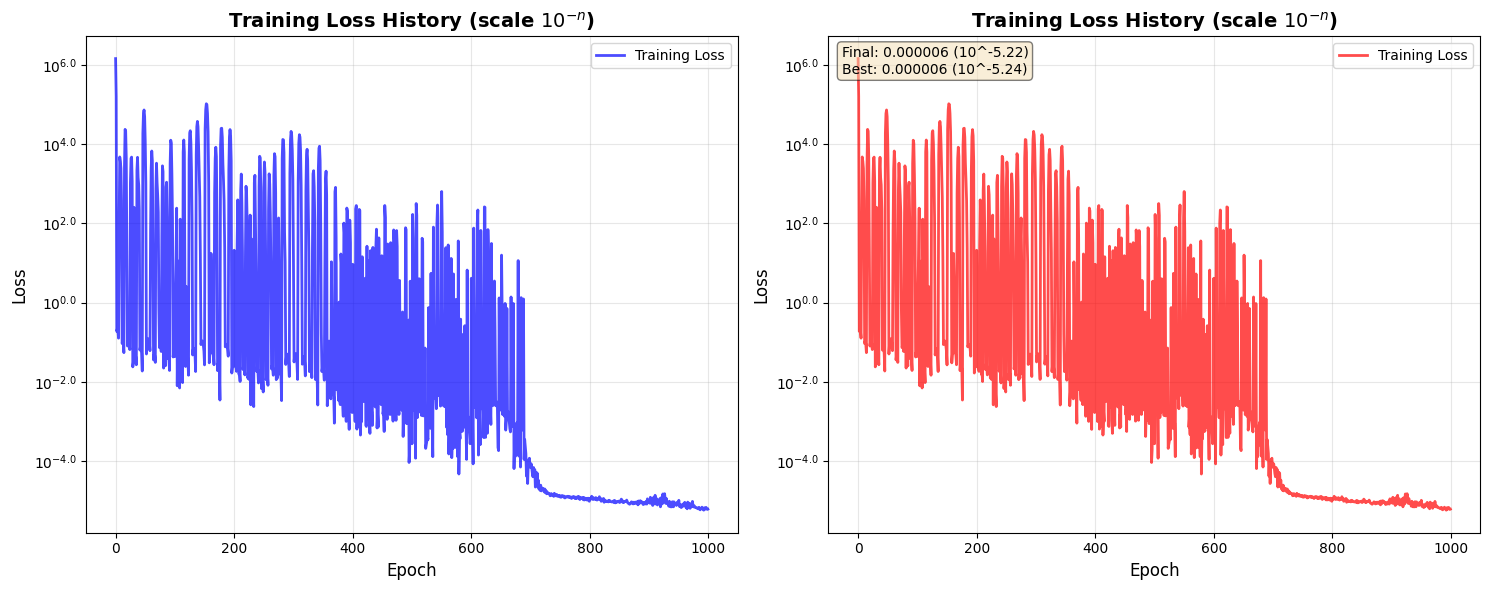

In [9]:
# Plot training history
plot_training_history(loss_history)

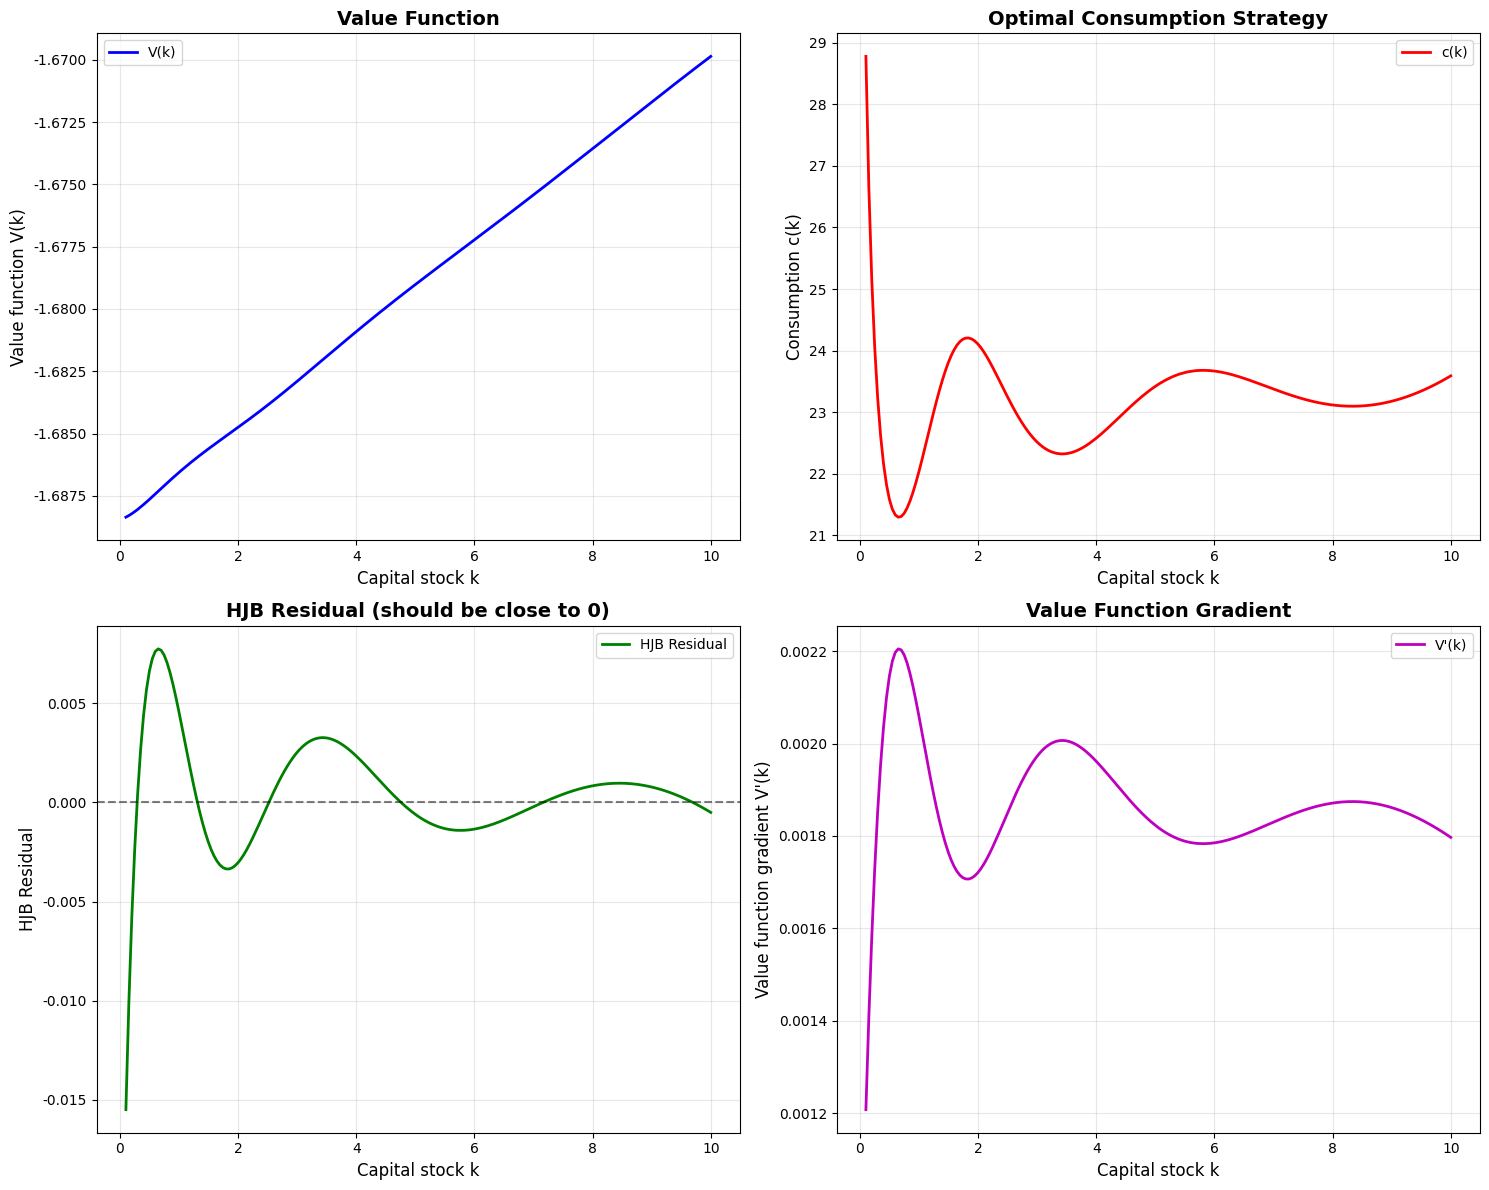

In [10]:
# Visualize model results
visualize_results(net)

## Customize Loss Function

You can modify the `loss_function` and `compute_hjb_residual` functions here to implement your own loss function.

The current framework provides:
- Neural network approximation of value function $V(k)$
- HJB residual computation framework
- Optimal consumption strategy derived from first-order conditions
- Complete training and visualization pipeline

### Modification Suggestions:

1. **Modify loss function**: Add boundary conditions, regularization terms, etc. in `loss_function`
2. **Modify HJB residual**: Adjust the specific form of HJB equation in `compute_hjb_residual`
3. **Add boundary conditions**: Include penalty terms for boundary conditions in the loss function
4. **Adjust network architecture**: Modify the hidden layer structure of `ValueFunctionNet`